In [ ]:
# https://curiousily.com/posts/intent-recognition-with-bert-using-keras-and-tensorflow-2/
!pip install transformers

     |████████████████████████████████| 1.9MB 15.1MB/s 
     |████████████████████████████████| 890kB 53.0MB/s 
     |████████████████████████████████| 3.2MB 49.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=f6e50cb3aa3a502dc4a907ae298320a65c2b63777e7682a21d36851bf36efc56
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
#import torch
#import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D, Dropout, Flatten

import nltk
nltk.download('punkt')
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
import tensorflow as tf

# Refer: https://huggingface.co/transformers/model_doc/distilbert.html#

from transformers import DistilBertTokenizer, TFDistilBertModel

distil_bert = 'distilbert-base-uncased' # Name of the pretrained models

#DistilBERT 
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert)
model = TFDistilBertModel.from_pretrained(distil_bert)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# obtain the 768-dim vector correpsoding to [CLS] which is a sentence vector

e = tokenizer.encode("Hello, my dog is cute", add_special_tokens=False)
print(e)

input = tf.constant(e)[None, :]  # Batch size 1 
print(input)
print(type(input)) # shape: [1,8]

output = model(input)

print(type(output))
print(len(output))
print(output) #shape[1,8,768]

[7592, 1010, 2026, 3899, 2003, 10140]
tf.Tensor([[ 7592  1010  2026  3899  2003 10140]], shape=(1, 6), dtype=int32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'transformers.modeling_tf_outputs.TFBaseModelOutput'>
1
TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 6, 768), dtype=float32, numpy=
array([[[ 0.38972193,  0.5467995 , -0.38459677, ..., -0.5253337 ,
          0.01367688,  0.56384903],
        [ 0.43845326,  0.876746  , -0.28330076, ..., -0.5620738 ,
          0.02665663,  0.40951955],
        [ 0.41049933,  0.79409516, -0.09344609, ..., -0.5103541 ,
         -0.10695288,  0.9439159 ],
        [ 0.39254102,  0.8001838 , -0.39222106, ..., -0.6946572 ,
          0.0348276 ,  0.6961019 ],
        [ 0.15075013,  0.5452851 , -0.3423004 , ..., -0.36907884,
          0.174741  ,  0.7833769 ],
        [ 0.31804234,  0.54820365, -0.30959132, ..., -0.43574828,
          0.1411547 ,  0.38621908]]], dtype=float32)>, hidden_states=None, attentions=None)


In [ ]:
e.append(0)

In [ ]:
type(e)

list

In [ ]:
example = "hello my dog is cute"
print({x : tokenizer.encode(x, add_special_tokens=False, add_prefix_space=True) for x in example.split()})

Keyword arguments {'add_prefix_space': True} not recognized.
Keyword arguments {'add_prefix_space': True} not recognized.
Keyword arguments {'add_prefix_space': True} not recognized.
Keyword arguments {'add_prefix_space': True} not recognized.
Keyword arguments {'add_prefix_space': True} not recognized.


{'hello': [7592], 'my': [2026], 'dog': [3899], 'is': [2003], 'cute': [10140]}


In [ ]:
e = [7592]
input = tf.constant(e)[None, :]  # Batch size 1 

In [ ]:
out1 = model(input)[0][0][0]

In [ ]:
type(out1), len(out1)

(tensorflow.python.framework.ops.EagerTensor, 768)

In [ ]:
np.asarray(out1)

array([ 2.32776120e-01,  4.76879209e-01, -2.19871134e-01,  3.78656328e-01,
       -3.07531059e-01, -2.95904964e-01,  1.94648132e-01,  7.31927752e-01,
       -2.55313277e-01,  2.17678607e-01,  6.84512779e-02, -1.71965346e-01,
       -2.45904624e-01,  3.75734389e-01, -6.77017689e-01,  8.54006529e-01,
       -7.22324908e-01,  4.88271594e-01, -4.00989056e-01,  1.72128975e-01,
        2.62488842e-01,  4.39205021e-03,  1.36106133e-01,  1.11298561e-01,
       -5.90893626e-02, -2.64075637e-01, -1.82086498e-01,  3.67500067e-01,
       -2.20275313e-01, -1.18731916e-01, -4.01159257e-01, -3.72633815e-01,
        4.73484755e-01,  2.72977591e-01, -3.52759123e-01, -5.61767936e-01,
        9.44630921e-01, -1.39072031e-01, -4.91062850e-01, -4.48406935e-01,
       -4.15415645e-01,  6.95135444e-03,  2.13896602e-01,  6.76606417e-01,
        6.47405207e-01, -3.79909933e-01,  5.32617927e-01,  5.39805055e-01,
        5.16024053e-01,  5.01259863e-01, -2.40121946e-01,  2.86722988e-01,
        2.86455661e-01,  

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/Multi-Task-W2V/data/'
#'Pos_neg_merged_data.csv'
data= pd.read_csv(folder_path + 'Pos_neg_merged_data.csv',encoding= 'unicode_escape')
data.head()

,sentiment,confidence,text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.
1,positive,0.3486,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...


In [ ]:
for i in range(10):
  print(data.text[i])

@VirginAmerica What @dhepburn said.
@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica I didn't today... Must mean I need to take another trip!
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
@VirginAmerica yes, nearly every time I fly VX this ÂÃÃear wormÂÃÂ wonÂÃÂªt go away :)
@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP
@virginamerica Well, I didn'tÂÃ_but NOW I DO! :-D
@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.


In [ ]:
data.shape

(18445, 3)

In [ ]:
# helper functions for pre-processing
def replace_url(string): # cleaning of URL
    text = re.sub(r'http\S+', 'LINK', string)
    return text


def replace_email(text):#Cleaning of Email related text
    line = re.sub(r'[\w\.-]+@[\w\.-]+','MAIL',str(text))
    return "".join(line)

def rep(text):#cleaning of non standard words
    grp = text.group(0)
    if len(grp) > 3:
        return grp[0:2]
    else:
        return grp# can change the value here on repetition
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert

def find_dollar(text):#Finding the dollar sign in the text
    line=re.sub(r'\$\d+(?:\.\d+)?','PRICE',text)
    return "".join(line)

def replace_emoji(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text) 

puncts = [':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']', '"','ª', '·',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '★', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '∞', '∙', '）', '↓', '、', '│', '（', '»', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

def clean_text(text: str) -> str:
    text = str(text)
    for punct in puncts:
        if punct in text:
            text = text.replace(punct, f'')
    return text
   
def replace_asterisk(text):
    text = re.sub("\*", 'ABUSE ', text)
    return text

def remove_duplicates(text):
    text = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text)
    return text
def change(text):
    if(text == ''):
        return text
  #calling the subfunctions in the cleaning function
    text = replace_email(text)
    text = replace_url(text)
    text = unique_char(rep,text)
    text = replace_asterisk(text)
    text = remove_duplicates(text)
    text = clean_text(text)
    text = text.strip()
    return text

In [ ]:
data['text'] = data['text'].apply(lambda x : change(x))

In [ ]:
data.sentiment.value_counts()

negative    10397
neutral      5261
positive     2786
Name: sentiment, dtype: int64

In [ ]:
# remove samples with less number of words
temp_index = []
for i in range(len(data)):
  tokenize_text = nltk.word_tokenize(data.text[i])
  if len(tokenize_text) < 8:
    #print(data.cleaned_text[i])
    temp_index.append(i)

In [ ]:
len(temp_index)
df = data.drop(data.index[temp_index])
df = df.reset_index(drop=True)

In [ ]:
df.sentiment.value_counts(), df.shape

(negative    9962
 neutral     4658
 positive    2263
 Name: sentiment, dtype: int64, (16883, 3))

In [ ]:
# reduce negative samples
temp_negative = []
for i in range(len(df)):
  if df.sentiment[i] == 'negative':
    temp_negative.append(i)

len(temp_negative)

9962

In [ ]:
df2 = df.drop(df.index[temp_negative[2350:]])
df2 = df2.reset_index(drop=True)

In [ ]:
df2.sentiment.value_counts()

neutral     4658
negative    2350
positive    2263
Name: sentiment, dtype: int64

In [ ]:
# reduce negative samples
temp_neutral = []
for i in range(len(df2)):
  if df2.sentiment[i] == 'neutral':
    temp_neutral.append(i)

len(temp_neutral)

4658

In [ ]:
df3 = df2.drop(df2.index[temp_neutral[2330:]])
df3 = df3.reset_index(drop=True)

In [ ]:
df3.sentiment.value_counts()

negative    2350
neutral     2330
positive    2263
Name: sentiment, dtype: int64

In [ ]:
# drop duplicates
temp_data = df3.drop_duplicates(subset=['text'], keep='last')
temp_data = temp_data.dropna()
data = temp_data.reset_index(drop=True)

In [ ]:
data.sentiment.value_counts(), data.shape

(negative    2350
 neutral     2275
 positive    2190
 Name: sentiment, dtype: int64, (6815, 3))

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 3

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 50

class_names = ['positive', 'negative', 'neutral']

In [ ]:
# map input words with model ids
word_ids = {}
words_temp = []
for i in tqdm(range(len(data))):
  example = data.text[i]
  for x in example.split():
    words_temp.append(x)
    temp = tokenizer.encode(x, add_special_tokens=False)
    for number in temp:
      word_ids[x] = number
  #{x : tokenizer.encode(x, add_special_tokens=False, add_prefix_space=True) for x in example.split()})

100%|██████████| 6815/6815 [00:13<00:00, 504.88it/s]


In [ ]:
# save ids words->ids as vocab.txt file
import os
for key, value in word_ids.items(): 
  #print(key, value[0])
  temp = key +" "+str(value)
  with open('vocab-v1.txt', 'a') as f1:
    f1.write(temp + os.linesep)

In [ ]:
word_ids['for'], len(word_ids), len(words_temp)

(2005, 15951, 119397)

In [ ]:
# embeddings
word_embeddings = {}
for key, value in tqdm(word_ids.items()):
  # chair 3242
  e = [value]
  input = tf.constant(e)[None, :]  # Batch size 1
  out1 = model(input)[0][0][0]
  final_out = np.asarray(out1)
  word_embeddings[key] = final_out

100%|██████████| 15951/15951 [14:35<00:00, 18.22it/s]


In [ ]:
len(word_embeddings)

15951

In [ ]:
temp_vocab = []
index_of_words = word_ids
for key, value in word_embeddings.items():
  if key in index_of_words:
    idx = index_of_words[key]
    temp_vocab.append(idx)

max(temp_vocab) # 29591, 29659

29659

In [ ]:
def create_embedding_matrix(word_embeddings, word_index, embedding_dim):
    vocab_size = max(temp_vocab) + 1  # Adding again 1 because of reserved 0 index 29567-all ids 
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, vector in word_embeddings.items():
      if word in word_index:
        idx = word_index[word] 
        #print(idx, word)
        embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
len(word_embeddings['today']), len(word_ids)

(768, 15951)

In [ ]:
embed_num_dims = 300
index_of_words = word_ids
vocab_size = max(temp_vocab) + 1
embedd_matrix = create_embedding_matrix(word_embeddings, index_of_words, embed_num_dims)
embedd_matrix.shape

(29660, 300)

In [ ]:
len(index_of_words), len(word_embeddings)

(15951, 15951)

In [ ]:
max(temp_vocab)

29659

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    #print(word)
    entry = embedd_matrix[index_of_words[word]]
    #print(entry)
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 15951
New words found: 0


In [ ]:
# Embedding layer before the actaul BLSTM 
vocab_size = 29660
max_seq_len = 50
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
# Convolution
kernel_size = 3
filters = 256

model_cnn = Sequential()
model_cnn.add(embedd_layer)
model_cnn.add(Conv1D(filters, kernel_size, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           8898000   
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 256)           230656    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 9,195,219
Trainable params: 297,219
Non-trainable params: 8,898,000
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# path to save weights
#path_w = '/content/drive/My Drive/DataToBiz/speech_to_emotion_engine/models/'
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights_datasetv2_cnnv2.hdf5', verbose=1, save_best_only=True)

In [ ]:
data.head()

,sentiment,confidence,text
0,positive,0.3486,VirginAmerica plus you've added commercials to...
1,neutral,0.6837,VirginAmerica I didn't today... Must mean I ne...
2,negative,1.0000,VirginAmerica it's really aggressive to blast ...
3,negative,1.0000,VirginAmerica and it's a really big bad thing ...
4,negative,1.0000,VirginAmerica seriously would pay 30 a flight ...


In [ ]:
data=df3
# split dataset
from sklearn.model_selection import train_test_split
X = data.text
y = data.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle=True)
print(X_train.shape)
print(X_test.shape)

(5554,)
(1389,)


In [ ]:
temp_neg = []
temp_pos = []
temp_neu = []
for label in y_test:
  if label=='neutral':
    temp_neu.append(label)
  if label == 'negative':
    temp_neg.append(label)
  if label=='positive':
    temp_pos.append(label)

print(len(temp_neg), len(temp_pos), len(temp_neu)) # ~1800, ~450


485 442 462


In [ ]:
X_train_tokenized = X_train.apply((lambda x: tokenizer.encode(x, add_special_tokens=False)))
X_test_tokenized = X_test.apply((lambda x: tokenizer.encode(x, add_special_tokens=False)))

In [ ]:
X_train_tokenized

2258    [2142, 1045, 2288, 2009, 2085, 1012, 2876, 100...
964     [2142, 2123, 1005, 1056, 2156, 1037, 2074, 101...
6103    [3915, 4313, 14035, 1045, 2363, 1037, 22953, 2...
6696    [9706, 28061, 2860, 6207, 4297, 9706, 2140, 20...
6114    [3915, 4313, 14035, 3531, 3582, 2033, 2061, 10...
                              ...                        
3772    [4943, 11215, 2027, 3369, 2397, 3462, 2021, 82...
5191    [6892, 16558, 5657, 2748, 14403, 2630, 11772, ...
5226    [6892, 16558, 5657, 1998, 1059, 2015, 3501, 21...
5390    [6892, 16558, 5657, 7118, 1059, 1037, 5883, 20...
860     [2142, 1045, 6406, 1037, 8394, 4524, 3189, 200...
Name: text, Length: 5554, dtype: object

In [ ]:
max_seq_len = 50
X_train_pad = pad_sequences(X_train_tokenized, maxlen = max_seq_len, padding='post')
X_test_pad = pad_sequences(X_test_tokenized, maxlen = max_seq_len, padding='post')

X_train_pad

array([[ 2142,  1045,  2288, ...,     0,     0,     0],
       [ 2142,  2123,  1005, ...,     0,     0,     0],
       [ 3915,  4313, 14035, ...,     0,     0,     0],
       ...,
       [ 6892, 16558,  5657, ...,     0,     0,     0],
       [ 6892, 16558,  5657, ...,     0,     0,     0],
       [ 2142,  1045,  6406, ...,     0,     0,     0]], dtype=int32)

In [ ]:
y_test.unique(), len(y_test)

(array(['negative', 'neutral', 'positive'], dtype=object), 1389)

In [ ]:
encoding = {
    'neutral': 0,
    'positive': 1,
    'negative': 2,
}

# Integer labels
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
batch_size = 64
epochs = 30

hist = model_cnn.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test), 
                 callbacks=[early_stopping, checkpointer])

Epoch 1/30
87/87 [==============================] - 6s 9ms/step - loss: 1.0268 - accuracy: 0.5195 - val_loss: 0.6477 - val_accuracy: 0.7120

Epoch 00001: val_loss improved from inf to 0.64770, saving model to weights_datasetv2_cnnv2.hdf5
Epoch 2/30
87/87 [==============================] - 0s 5ms/step - loss: 0.5680 - accuracy: 0.7589 - val_loss: 0.5814 - val_accuracy: 0.7531

Epoch 00002: val_loss improved from 0.64770 to 0.58137, saving model to weights_datasetv2_cnnv2.hdf5
Epoch 3/30
87/87 [==============================] - 0s 5ms/step - loss: 0.4040 - accuracy: 0.8421 - val_loss: 0.5794 - val_accuracy: 0.7459

Epoch 00003: val_loss improved from 0.58137 to 0.57936, saving model to weights_datasetv2_cnnv2.hdf5
Epoch 4/30
87/87 [==============================] - 0s 5ms/step - loss: 0.3433 - accuracy: 0.8654 - val_loss: 0.5136 - val_accuracy: 0.7826

Epoch 00004: val_loss improved from 0.57936 to 0.51356, saving model to weights_datasetv2_cnnv2.hdf5
Epoch 5/30
87/87 [==================

In [ ]:
predictions = model_cnn.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)

In [ ]:
predictions

array([2, 0, 1, ..., 1, 0, 1])

In [ ]:
class_names = ['positive', 'negative', 'neutral']
predictions = model_cnn.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
y_test1 = np.argmax(y_test, axis=1)
y_test1 = [class_names[x] for x in y_test1]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test1, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test1, predictions, average='micro') * 100))

Accuracy: 77.83%

F1 Score: 77.83


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 77.83


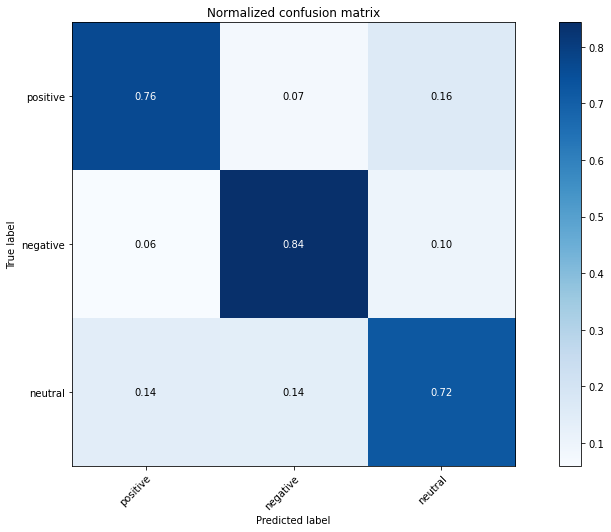

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(y_test1, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test1, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
model_cnn.save("my_model2")

INFO:tensorflow:Assets written to: my_model2/assets


In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model("my_model2")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

In [ ]:
# dynamic range quantization

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# predictions
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
pred_cls_2 = []
for i in range(len(X_test_pad)):
    test_data = np.expand_dims(X_test_pad[i], axis=0)
    #test_data = X_test_pad[i]
    data = np.float32(test_data)
    #print(data)
    interpret_data = interpreter.set_tensor(input_details[0]['index'], data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_cls = output_data.argmax(axis=1)
    pred_cls_2.append(output_cls[0])

In [ ]:
pred_cls_2 = [class_names[pred] for pred in pred_cls_2]

In [ ]:
tokens1 = np.expand_dims(X_test_pad[0], axis=0)
#test_data = np.expand_dims(X_test_pad[i], axis=0)

In [ ]:
out1 = model_cnn.predict(tokens1)
out1.argmax(axis=1)


array([2])

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test1, pred_cls_2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test1, pred_cls_2, average='micro') * 100))

Accuracy: 77.83%

F1 Score: 77.83


In [ ]:
X_test

1328    united its funny how none of ur tweets back ar...
3764    SouthwestAir understand the weather, these kid...
5086    JetBlue is the best  Can't wait to use my trav...
5842    USAirways AmericanAir major issues getting out...
1941    united I see two flights with two seats in the...
                              ...                        
652     united nope, they told us it was time for them...
33      VirginAmerica when can I book my flight to Hawaii
5982    USAirways I'm enjoying my flights so far You'r...
44      VirginAmerica wish you flew out of Atlanta... ...
3308    united we had a wonderful flight attendant nam...
Name: text, Length: 1389, dtype: object

In [ ]:
y_test

1328    negative
3764     neutral
5086    positive
5842    positive
1941     neutral
          ...   
652     negative
33       neutral
5982    positive
44       neutral
3308    positive
Name: sentiment, Length: 1389, dtype: object

In [ ]:
X_test[1941], y_test[1941]

('united I see two flights with two seats in the morning can we get on those',
 'neutral')

In [ ]:
("united its funny how none of ur tweets back are helpful what I want is to read 'ya we'l change that so our customers get better service'",
 'negative')

('SouthwestAir understand the weather, these kids need to get home Nice kids doing volunteer work from a RI high school, please help',
 'neutral')
("JetBlue is the best  Can't wait to use my travel bank  for a FUN trip.",
 'positive')

("USAirways AmericanAir major issues getting out of Boston, but your crew has been exceptional. Let's see how things roll out in Philly.",
 'positive')
('united I see two flights with two seats in the morning can we get on those',
 'neutral')

In [ ]:
for text, label in zip(X_test, y_test):
  print(text, '-->', label)
  print('\n')

united its funny how none of ur tweets back are helpful what I want is to read 'ya we'l change that so our customers get better service' --> negative


SouthwestAir understand the weather, these kids need to get home Nice kids doing volunteer work from a RI high school, please help --> neutral


JetBlue is the best  Can't wait to use my travel bank  for a FUN trip. --> positive


USAirways AmericanAir major issues getting out of Boston, but your crew has been exceptional. Let's see how things roll out in Philly. --> positive


united I see two flights with two seats in the morning can we get on those --> neutral


united alright thank you. Much appreciated. --> positive


VirginAmerica come back to PHL already. We need you to take us out of this horrible cold. pleasecomeback LINK --> positive


united your website won't allow me to post the required document, i keep getting ABUSE were having technical difficultiesABUSE ABUSE --> negative


united wins top marks for customer service via

In [ ]:
united we had a wonderful flight attendant named Leah that was with us from lga to den, then den to anchorage --> positive